# BentoML Example: PyTorch Fashion MNIST Classification


[BentoML](http://bentoml.ai) is an open source platform for machine learning model serving and deployment. In this project we will use BentoML to package the image classifier model, and build a containerized REST API model server.

This notebook demonstrates how to use BentoML to turn a PyTorch model into a docker image containing a REST API server serving this model, how to use your ML service built with BentoML as a CLI tool, and how to distribute it a pypi package.

This example was built based on https://github.com/baldassarreFe/zalando-pytorch/blob/master/notebooks/4.0-fb-autoencoder.ipynb, if you are familiar with this, jump start to [Model Serving using BentoML](#Define-ML-service-with-BentoML)

![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=pytorch&ea=pytorch-fashion-mnist&dt=pytorch-fashion-mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install bentoml
!pip install torch torchvision sklearn pillow pandas numpy

In [1]:
import bentoml
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.autograd import Variable

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

## Prepare Dataset

PyTorch supports FashionMNIST now, so we can import it directly.

In [10]:
from torchvision.datasets import FashionMNIST
FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Load train and test set in batches of 1000.

The `28x28` images are scaled up to `29x29` so that combining convolutions and transposed convolutions would not chop off pixels from the reconstructed images.

In [11]:
batch_size = 1000

train_dataset = FashionMNIST(
    '../data', train=True, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = FashionMNIST(
    '../data', train=False, download=True, 
    transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Unsupervised reconstruction
Note that in this section we'll never use the image labels, the whole training is unsupervised.

### Autoencoder
The two components of the autoencoder are defined subclassing `nn.Module`, that gives more flexibility than `nn.Sequential`.

#### Encoder
A series of convolutions with `kernel_size=5` and `stride=2` is used to squeeze the images into a volume of 40x1x1, then a fully connected layer turns this vector in a vector of size `embedding_size`, that can be specified externally.

#### Decoder
The decoder takes up from where the encoder left, first transforming back the embedding of size `embedding_size` into a volume of size 40x1x1, then applying a series of Transposed Convolutions to yield an image of the same size of the original input.

At this time we can show some images in this Dataloader.

In [12]:
class Encoder(nn.Module):
    def __init__(self, embedding_size):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5, stride=2)
        self.fully = nn.Linear(40, embedding_size)

    def forward(self, x):
        # 1x29x29
        x = torch.relu(self.conv1(x))
        # 10x13x13
        x = torch.relu(self.conv2(x))
        # 20x5x5
        x = torch.relu(self.conv3(x))
        # 40x1x1
        x = x.view(x.data.shape[0], 40)
        # 40
        x = self.fully(x)
        # output_size
        return x

class Decoder(nn.Module):
    def __init__(self, input_size):
        super(Decoder, self).__init__()
        self.fully = nn.Linear(input_size, 40)
        self.conv1 = nn.ConvTranspose2d(40, 20, kernel_size=5, stride=2)
        self.conv2 = nn.ConvTranspose2d(20, 10, kernel_size=5, stride=2)
        self.conv3 = nn.ConvTranspose2d(10, 1, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = self.fully(x)
        x = x.view(x.data.shape[0], 40, 1, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))
        return x

We are going to use an embedding size of 20, this number has no particular reason, except that it is in the same range of the number of classes. Naively, the network could learn to encode coarse-grained information (i.e. the kind of dress) in half of the embedding vector and then use the other half for fine-grained information.

In [13]:
embedding_size = 20
encoder = Encoder(embedding_size)
decoder = Decoder(embedding_size)

autoencoder = nn.Sequential(encoder, decoder)

#### Sanity check
A 29x29 black and white image passed through the autoencoder should give the same output dimension

In [14]:
x = Variable(torch.ones(1, 1, 29, 29))
e = encoder(x)
d = decoder(e)

print('Input\t ', list(x.data.shape))
print('Embedding', list(e.data.shape))
print('Output\t ', list(d.data.shape))

Input	  [1, 1, 29, 29]
Embedding [1, 20]
Output	  [1, 1, 29, 29]


### Training

In [15]:
autoencoder.train()

loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters())
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, _) in enumerate(train_loader):
        data = Variable(data)
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = loss_fn(output, data)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    print('Epoch {}:\tloss {:.4f}'.format(epoch, epoch_loss[-1]))

Epoch 0:	loss 0.1308
Epoch 1:	loss 0.0715
Epoch 2:	loss 0.0462
Epoch 3:	loss 0.0371
Epoch 4:	loss 0.0311
Epoch 5:	loss 0.0266
Epoch 6:	loss 0.0246
Epoch 7:	loss 0.0234
Epoch 8:	loss 0.0225
Epoch 9:	loss 0.0216
Epoch 10:	loss 0.0209
Epoch 11:	loss 0.0204
Epoch 12:	loss 0.0200
Epoch 13:	loss 0.0196
Epoch 14:	loss 0.0192


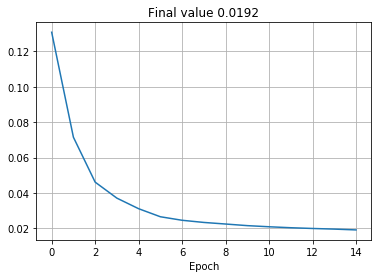

In [16]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [17]:
autoencoder.eval()
data, targets = next(test_loader.__iter__())
encodings = encoder(Variable(data))
outputs = decoder(encodings)

print('Test loss: {:.4f}'.format(loss_fn(outputs, Variable(data)).item()))

Test loss: 0.0193


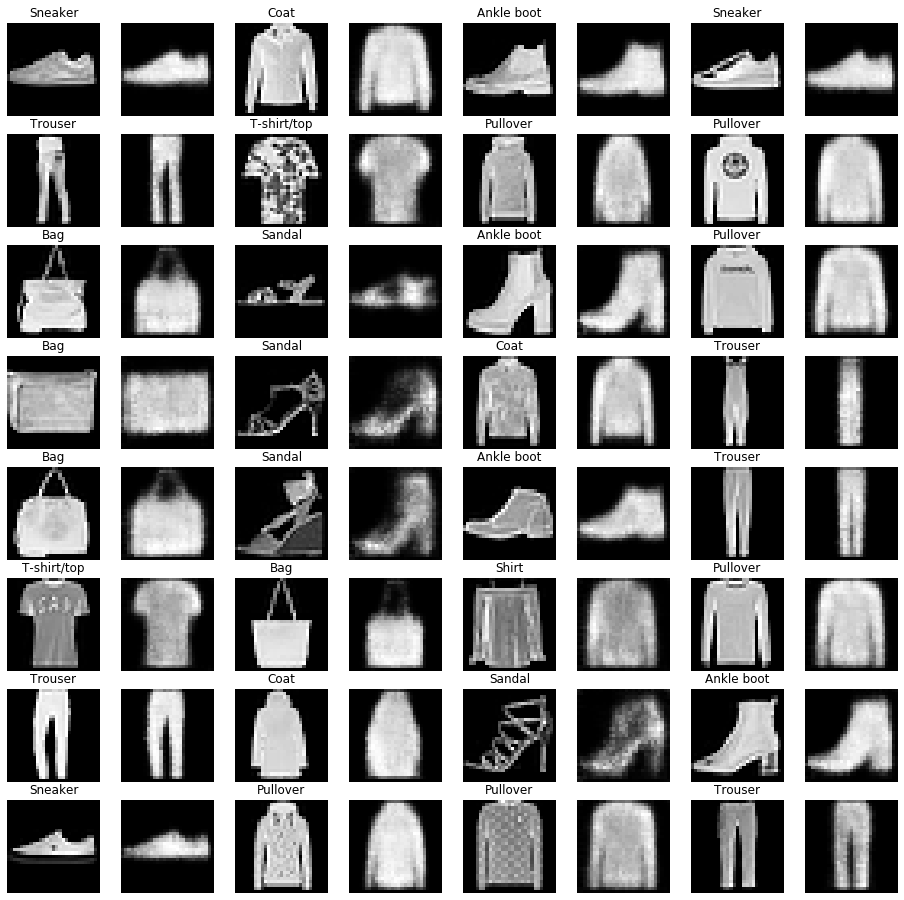

In [19]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.ravel()

zip_these = axes[::2], axes[1::2], data.numpy().squeeze(), outputs.data.numpy().squeeze(), targets
for ax1, ax2, original, reconstructed, target in zip(*zip_these):
    ax1.imshow(original, cmap='gray')
    ax1.axis('off')
    ax1.set_title(FASHION_MNIST_CLASSES[target])
    ax2.imshow(reconstructed, cmap='gray')
    ax2.axis('off')

### Embeddings

The embeddings are 20-dimensional, t-SNE is used to visualize them as clusters in 2D space.

Even though the autoencoder learned the embeddings in a completely unsupervised way we can observe the emergence of clusters:
- __shoes__ (sandals, sneakers and ankle boot) are clustered together
- __bags__ form a group on their own (they are the only images with a clear squared-rectangular shape)
- same goes for __trousers__, that form their own group
- all the others are quite mixed together, meaning that the network has learned the concept of _clothes for the upper body_, but is not able to tell a __coat__ from a __pullover__

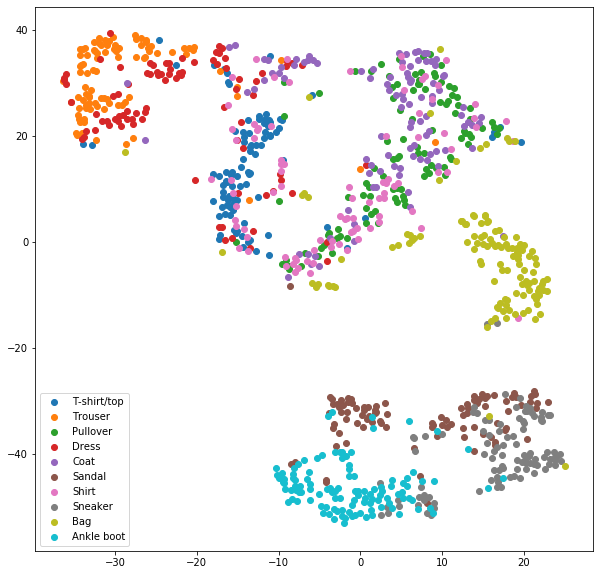

In [22]:
pca = TSNE(n_components=2)
encodings_2 = pca.fit_transform(encodings.data.numpy())
plt.figure(figsize=(10, 10))
for k in range(len(FASHION_MNIST_CLASSES)):
    class_indexes = (targets.numpy() == k)
    plt.scatter(encodings_2[class_indexes, 0], encodings_2[class_indexes, 1], label=FASHION_MNIST_CLASSES[k])
plt.legend();

## Supervised classification

Once trained in an unsupervised fashion, the encoder module can be used to generate _fashion_ embeddings (see what I did here?), that can then be used to train a simple classifier on the original labels.

### Model
The weights of the encoder are freezed, so only the classifier will be trained.

(later on, when the classifier starts performing decently, we could unfreeze them and do some fine-tuning)

In [24]:
for param in encoder.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
    encoder, 
    nn.Linear(embedding_size, 15),
    nn.ReLU(),
    nn.Linear(15, len(FASHION_MNIST_CLASSES)),
    nn.LogSoftmax()
)

### Training

In [25]:
classifier.train()

loss_fn = nn.NLLLoss()
optimizer = optim.Adam([p for p in classifier.parameters() if p.requires_grad])
epoch_loss = []

for epoch in range(15):
    batch_loss = []
    for batch_num, (data, targets) in enumerate(train_loader):
        data, targets = Variable(data), Variable(targets)
        optimizer.zero_grad()
        output = classifier(data)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    epoch_loss.append(sum(batch_loss) / len(batch_loss))
    accuracy = accuracy_score(targets.data.numpy(), output.data.numpy().argmax(axis=1))
    print('Epoch {}:\tloss {:.4f}\taccuracy {:.2%}'.format(epoch, epoch_loss[-1], accuracy))

/opt/anaconda3/envs/bentoml-dev-py36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 0:	loss 2.5062	accuracy 60.50%
Epoch 1:	loss 0.9973	accuracy 69.30%
Epoch 2:	loss 0.8290	accuracy 70.90%
Epoch 3:	loss 0.7641	accuracy 72.70%
Epoch 4:	loss 0.7297	accuracy 75.40%
Epoch 5:	loss 0.7095	accuracy 71.00%
Epoch 6:	loss 0.6951	accuracy 75.30%
Epoch 7:	loss 0.6838	accuracy 74.10%
Epoch 8:	loss 0.6764	accuracy 74.80%
Epoch 9:	loss 0.6682	accuracy 74.70%
Epoch 10:	loss 0.6625	accuracy 75.20%
Epoch 11:	loss 0.6581	accuracy 75.20%
Epoch 12:	loss 0.6531	accuracy 75.70%
Epoch 13:	loss 0.6485	accuracy 75.70%
Epoch 14:	loss 0.6450	accuracy 78.50%


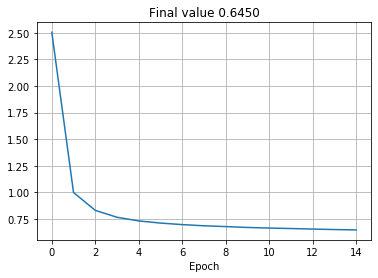

In [27]:
plt.plot(epoch_loss)
plt.title('Final value {:.4f}'.format(epoch_loss[-1]))
plt.xlabel('Epoch')
plt.grid(True)

### Evaluation

Reconsruction evaluation on a single batch

In [28]:
classifier.eval()
data, targets = next(test_loader.__iter__())
outputs = classifier(Variable(data))
log_probs, output_classes = outputs.max(dim=1)

accuracy = accuracy_score(targets.numpy(), output_classes.data.numpy())
print('Accuracy: {:.2%}'.format(accuracy))

Accuracy: 73.30%


/opt/anaconda3/envs/bentoml-dev-py36/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


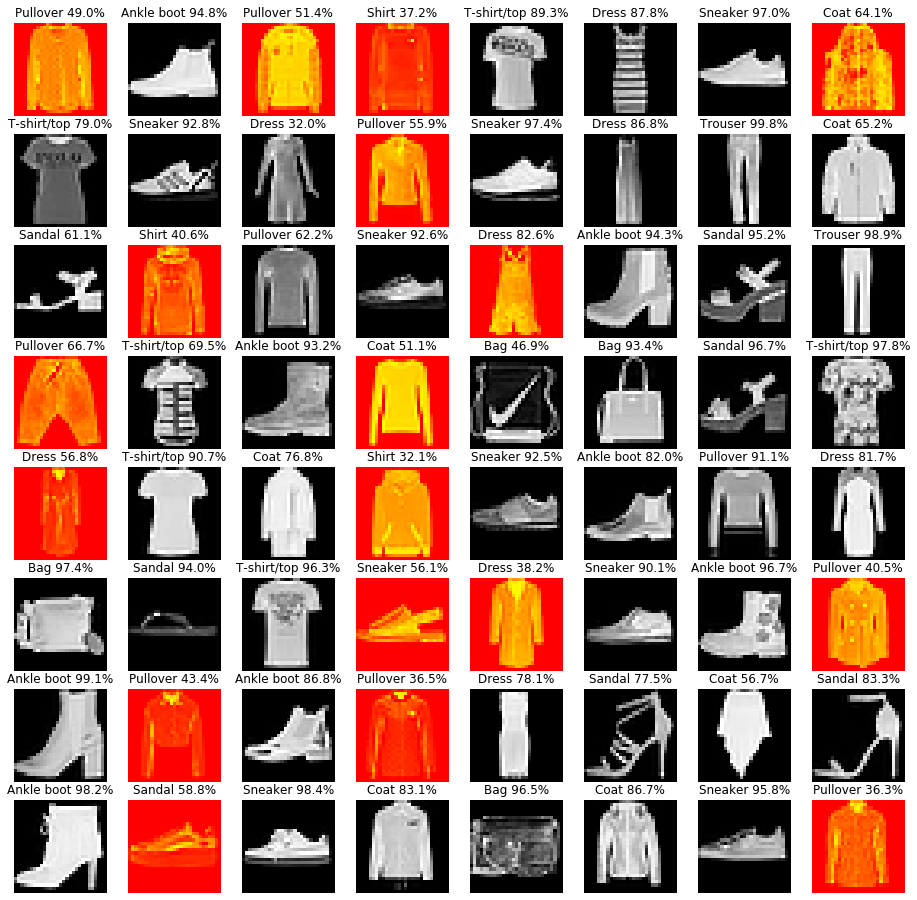

In [29]:
fig, axex = plt.subplots(8, 8, figsize=(16, 16))

zip_these = axex.ravel(), log_probs.data.exp(), output_classes.data, targets, data.numpy().squeeze()
for ax, prob, output_class, target, img in zip(*zip_these):
    ax.imshow(img, cmap='gray' if output_class == target else 'autumn')
    ax.axis('off')
    ax.set_title('{} {:.1%}'.format(FASHION_MNIST_CLASSES[output_class], prob))

## Define BentoService for model serving

In [33]:
%%writefile pytorch_fashion_mnist.py

import bentoml
from PIL import Image
import torch
from torchvision import transforms

from bentoml.artifact import PytorchModelArtifact
from bentoml.handlers import ImageHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['torch', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('classifier')])
class PyTorchFashionClassifier(bentoml.BentoService):

    @bentoml.api(ImageHandler, pilmode='L')
    def predict(self, images):
        transform=transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()])
        img_tensors = []
        for image in images:
            img = Image.fromarray(image).resize((28, 28))
            img_tensors.append(transform(img))
        outputs = self.artifacts.classifier(torch.stack(img_tensors))
        _, output_classes = outputs.max(dim=1)
        
        return [FASHION_MNIST_CLASSES[output_class] for output_class in output_classes]

Overwriting pytorch_fashion_mnist.py


## Save BentoService


In [31]:
# 1) import the custom BentoService defined above
from pytorch_fashion_mnist import PyTorchFashionClassifier

# 2) `pack` it with required artifacts
bento_svc = PyTorchFashionClassifier()
bento_svc.pack('classifier', classifier)

# 3) save your BentoSerivce
saved_path = bento_svc.save()

[2020-05-27 18:26:14,194] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-05-27 18:26:14,219] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_dependencies=['torchvision'])` when defining a BentoService
[2020-05-27 18:26:14,420] WARNING - BentoML local 

no previously-included directories found matching 'e2e_tests'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'benchmark'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check
creating BentoML-0.5.2+233.g8538e6f
creating BentoML-0.5.2+233.g8538e6f/BentoML.egg-info
creating BentoML-0.5.2+233.g8538e6f/bentoml
creating BentoML-0.5.2+233.g8538e6f/bentoml/artifact
creating BentoML-0.5.2+233.g8538e6f/bentoml/bundler
creating BentoML-0.5.2+233.g8538e6f/bentoml/cli
creating BentoML-0.5.2+233.g8538e6f/bentoml/clipper
creating BentoML-0.5.2+233.g8538e6f/bentoml/configuration
creating BentoML-0.5.2+233.g8538e6f/bentoml/configuration/__pycache__
creating BentoML-0.5.2+233.g8538e6f/bentoml/deployment
creating BentoML-0.5.2+233.g8538e6f/bentoml/deployment/aws_lambda
creating BentoML-0.5.2+233.g8538e6f/bentoml/deployment/sagemaker
creating BentoML-0.5.2+233.g8538e6f/bentoml/handlers
creating BentoML-0.5.2+233.g8538e6f/bentoml/marshal
creating BentoML-0.5.2+233.g8538e6f/bentoml/migrations
creating BentoML-0.5.2+233.g8538e6f/bentoml/migrations/__pycache__
creating BentoML-0.5.2+233.g8538e6f/bentoml/migrations

Use `bentoml get <BentoService_Name>` to get list of service versions

In [23]:
!bentoml get PyTorchFashionClassifier

BENTO_SERVICE                                   AGE            APIS                   ARTIFACTS
PyTorchFashionClassifier:20200213142355_A51D6E  47.93 seconds  predict<ImageHandler>  classifier<PytorchModelArtifact>


With version info, `bentoml get` display additional information and metadata

In [24]:
!bentoml get PyTorchFashionClassifier:20200213142355_A51D6E

{
  "name": "PyTorchFashionClassifier",
  "version": "20200213142355_A51D6E",
  "uri": {
    "type": "LOCAL",
    "uri": "/Users/bozhaoyu/bentoml/repository/PyTorchFashionClassifier/20200213142355_A51D6E"
  },
  "bentoServiceMetadata": {
    "name": "PyTorchFashionClassifier",
    "version": "20200213142355_A51D6E",
    "createdAt": "2020-02-13T22:24:21.765194Z",
    "env": {
      "condaEnv": "name: bentoml-PyTorchFashionClassifier\nchannels:\n- defaults\ndependencies:\n- python=3.7.3\n- pip\n",
      "pipDependencies": "bentoml==0.6.2\ntorch\nnumpy\ntorchvision\nscikit-learn\nimageio",
      "pythonVersion": "3.7.3"
    },
    "artifacts": [
      {
        "name": "classifier",
        "artifactType": "PytorchModelArtifact"
      }
    ],
    "apis": [
      {
        "name": "predict",
        "handlerType": "ImageHandler",
        "docs": "BentoService API",
        "handlerConfig": {
          "accept_image_formats": [
            ".jpg",
            ".png",
            ".jpeg",


Test and validate BentoService with `bentoml run`

In [25]:
!bentoml run PyTorchFashionClassifier:20200213142355_A51D6E predict --input sample_image.png

[2020-02-13 14:26:27,300] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-13 14:26:27,314] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.2,  but loading from BentoML version 0.6.2+8.gd95a887
[2020-02-13 14:26:27,867] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

## Model Serving via REST API

In your termnial, run the following command to start the REST API server:### Run REST API server

In [32]:
!bentoml serve {saved_path}

[2020-05-27 18:26:58,532] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-05-27 18:26:58,547] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.5.2,  but loading from BentoML version 0.5.2+233.g8538e6f
[2020-05-27 18:26:59,008] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will 

### Call REST API from a client

Sending POST request from termnial:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@sample_image.png
```

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/png" --data-binary @sample_image.png
```

Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

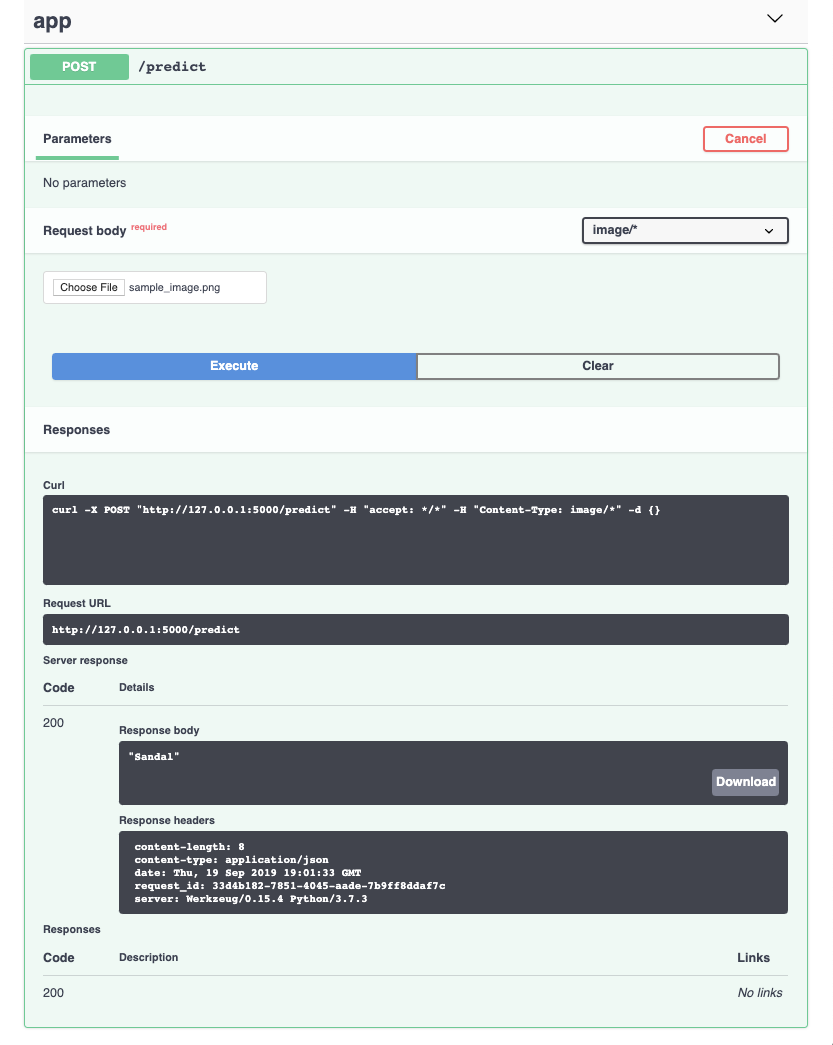

## Use BentoService as PyPI package

In [26]:
!pip install {saved_path}

Processing /Users/bozhaoyu/bentoml/repository/PyTorchFashionClassifier/20200213142355_A51D6E
  Created wheel for PyTorchFashionClassifier: filename=PyTorchFashionClassifier-20200213142355_A51D6E-py3-none-any.whl size=227357 sha256=f6392e9808e635494a70bc99f38324bd6a95e87faf78e09a98bf9dabd1f83358
  Stored in directory: /private/var/folders/kn/xnc9k74x03567n1mx2tfqnpr0000gn/T/pip-ephem-wheel-cache-g_t2q7hh/wheels/8d/74/85/123929307607d586ca80844b9f8a112a628d7f7e1a273c94dc
Successfully built PyTorchFashionClassifier


In [27]:
!PyTorchFashionClassifier info

[2020-02-13 14:28:34,473] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-13 14:28:34,484] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.2,  but loading from BentoML version 0.6.2+8.gd95a887
{
  "name": "PyTorchFashionClassifier",
  "version": "20200213142355_A51D6E",
  "created_at": "2020-02-13T22:24:21.765194Z",
  "env": {
    "conda_env": "name: bentoml-PyTorchFashionClassifier\nchannels:\n- defaults\ndependencie

In [29]:
!PyTorchFashionClassifier run predict --input sample_image.png

[2020-02-13 14:29:14,734] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.6.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-13 14:29:14,745] WARNING - Saved BentoService bundle version mismatch: loading BentoServie bundle create with BentoML version 0.6.2,  but loading from BentoML version 0.6.2+8.gd95a887
[2020-02-13 14:29:14,748] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be

## Containerize REST API server with Docker

** _Make sure you have `docker` installed, note that it is not available when running in Google Colaboratory_

In [21]:
!cd {saved_path} && docker build . -t pytorch-fashion-mnist

Sending build context to Docker daemon  133.6kB
Step 1/11 : FROM continuumio/miniconda3
 ---> ae46c364060f
Step 2/11 : ENTRYPOINT [ "/bin/bash", "-c" ]
 ---> Using cache
 ---> 2f135ada8e2d
Step 3/11 : EXPOSE 5000
 ---> Using cache
 ---> 738f652d09ae
Step 4/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 70c62a45013a
Step 5/11 : RUN conda update conda -y       && conda install pip numpy scipy       && pip install gunicorn six
 ---> Using cache
 ---> fe5d966ecc35
Step 6/11 : COPY . /bento
 ---> d00c6768ebbe
Step 7/11 : WORKDIR /bento
 ---> Running in 65e4f1f8e11f
Removing intermediate container 65e4f1f8e11f
 ---> d0a6e7065765
Step 8/11 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in 6166f7e1de32
Solving environment: ...working... 
The environment is inconsistent, please check the package plan carefully
The followin

In [22]:
!docker run -p 5000:5000 pytorch-fashion-mnist

[2019-09-19 19:57:42 +0000] [1] [INFO] Starting gunicorn 19.9.0
[2019-09-19 19:57:42 +0000] [1] [INFO] Listening at: http://0.0.0.0:5000 (1)
[2019-09-19 19:57:42 +0000] [1] [INFO] Using worker: sync
[2019-09-19 19:57:42 +0000] [10] [INFO] Booting worker with pid: 10
[2019-09-19 19:57:42 +0000] [11] [INFO] Booting worker with pid: 11
[2019-09-19 19:57:42 +0000] [12] [INFO] Booting worker with pid: 12
^C
[2019-09-19 20:04:03 +0000] [1] [INFO] Handling signal: int
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
[2019-09-19 20:04:03 +0000] [12] [INFO] Worker exiting (pid: 12)
[2019-09-19 20:04:03 +0000] [10] [INFO] Worker exiting (pid: 10)
[2019-09-19 20:04:03 +0000] [11] [INFO] Worker exiting (pid: 11)


## Deploy BentoService as REST API server to the cloud

BentoML support deployment to multiply cloud provider services, such as AWS Lambda, AWS Sagemaker, Google Cloudrun and etc. You can find the full list and guide on the documentation site at https://docs.bentoml.org/en/latest/deployment/index.html


For this project, we are going to deploy to AWS Sagemaker

Deploy to Sagemaker with single command `bentoml sagemaker deploy`

In [30]:
!bentoml sagemaker deploy pytorch-fashion -b PyTorchFashionClassifier:20200213142355_A51D6E --api-name predict

Deploying Sagemaker deployment \[2020-02-13 14:31:00,094] INFO - Step 1/11 : FROM continuumio/miniconda3:4.7.12
[2020-02-13 14:31:00,095] INFO - 

[2020-02-13 14:31:00,095] INFO -  ---> 406f2b43ea59

[2020-02-13 14:31:00,095] INFO - Step 2/11 : EXPOSE 8080
[2020-02-13 14:31:00,095] INFO - 

[2020-02-13 14:31:00,096] INFO -  ---> Using cache

[2020-02-13 14:31:00,096] INFO -  ---> 85b4bb5fff81

[2020-02-13 14:31:00,096] INFO - Step 3/11 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential     && apt-get install -y nginx      && rm -rf /var/lib/apt/lists/*
[2020-02-13 14:31:00,096] INFO - 

[2020-02-13 14:31:00,096] INFO -  ---> Using cache

[2020-02-13 14:31:00,096] INFO -  ---> 66280bc479d1

[2020-02-13 14:31:00,096] INFO - Step 4/11 : RUN conda install pip numpy scipy       && pip install gunicorn gevent
[2020-02-13 14:31:00,097] INFO - 

[2020-02-13 14:31:00,097] INFO -  ---> Using cache

[2020-02-13 14

`bentoml sagemaker list` lists all Sagemaker deployments

In [31]:
!bentoml sagemaker list

NAME             NAMESPACE    PLATFORM       BENTO_SERVICE                                   STATUS    AGE
pytorch-fashion  bobo         aws-sagemaker  PyTorchFashionClassifier:20200213142355_A51D6E  running   22 minutes and 57.12 seconds


In [34]:
!bentoml sagemaker get pytorch-fashion

{
  "namespace": "bobo",
  "name": "pytorch-fashion",
  "spec": {
    "bentoName": "PyTorchFashionClassifier",
    "bentoVersion": "20200213142355_A51D6E",
    "operator": "AWS_SAGEMAKER",
    "sagemakerOperatorConfig": {
      "region": "us-west-2",
      "instanceType": "ml.m4.xlarge",
      "instanceCount": 1,
      "apiName": "predict"
    }
  },
  "state": {
    "state": "RUNNING",
    "infoJson": {
      "EndpointName": "bobo-pytorch-fashion",
      "EndpointArn": "arn:aws:sagemaker:us-west-2:192023623294:endpoint/bobo-pytorch-fashion",
      "EndpointConfigName": "bobo-pytorch-fash-PyTorchFashionClassi-20200213142355-A51D6E",
      "ProductionVariants": [
        {
          "VariantName": "bobo-pytorch-fash-PyTorchFashionClassi-20200213142355-A51D6E",
          "DeployedImages": [
            {
              "SpecifiedImage": "192023623294.dkr.ecr.us-west-2.amazonaws.com/pytorchfashionclassifier-sagemaker:20200213142355_A51D6E",
              "ResolvedImage": "192023623294.dkr.

Test and validate Sagemaker deployment with `aws sagemaker-runtime invoke-endpoint` command

In [35]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name bobo-pytorch-fashion \
--body fileb:///Users/bozhaoyu/src/bento_gallery/pytorch/fashion-mnist/sample_image.png \
--content-type image/png output.json && cat output.json

{
    "ContentType": "application/json",
    "InvokedProductionVariant": "bobo-pytorch-fash-PyTorchFashionClassi-20200213142355-A51D6E"
}
"Bag"

Clean up Sagemaker deployment with `bentoml sagemaker delete`

In [36]:
!bentoml sagemaker delete pytorch-fashion

Successfully deleted AWS Sagemaker deployment "pytorch-fashion"
